# Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dirrac.data.synthetic_data import DataSynthesizer
from dirrac.classifier.logistic import logistic_classifier

In [2]:
# Matplotlib config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 13

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

# Synthesize data and train classifiers

In [3]:
# Original data parameters
mean_0 = np.ones(2) * (-3)
mean_1 = np.ones(2) * 3
cov_0 = cov_1 = np.identity(2)
n = 1000 # 1000 samples, 500 each class

""" Here we synthesize original data, 
and 100 data distribution shifts 
with 33 mean shifts, 33 covariance shifts and 34 mean and covariance shift
Shifted parameters \alpha=[1.5, 0] and \beta=3 """
sd = DataSynthesizer(mean_0, cov_0, mean_1, cov_1, n)
features, labels = sd.synthesize_modes_data(100, [0.33, 0.33, 0.34], [0.1, 0.1], same=True)

In [4]:
# Train 101 classifiers, the first is on the original dataset and the others are on shifted data
all_coef = np.zeros((101, 2))
for i in range(101):
    coef = logistic_classifier(features[i], labels[i])[1].T
    all_coef[i] = np.squeeze(coef)

# Get theta with 3 types of distribution shifts
mean_shift = all_coef[1:34]
cov_shift = all_coef[34:67]
both_shift = all_coef[67:101]

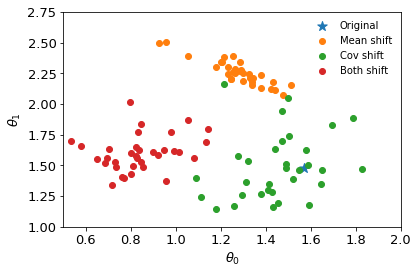

In [5]:
# Plot
fig, ax = plt.subplots()
ax.scatter(all_coef[0][0], all_coef[0][1], s=100, marker='*', label = 'Original')
ax.scatter(mean_shift[:, 0], mean_shift[:, 1], marker='o', label = 'Mean shift')
ax.scatter(cov_shift[:, 0], cov_shift[:, 1], marker='o', label = 'Cov shift')
ax.scatter(both_shift[:, 0], both_shift[:, 1], marker='o', label = 'Both shift')

ax.set(xlabel='$\\theta_{0}$', ylabel='$\\theta_{1}$')
ax.legend(loc='upper right', frameon=False)

ax.set_xlim(0.5, 2)
ax.set_ylim(1, 2.75)
plt.tight_layout()

if not os.path.exists('result/figure6/'):
    os.makedirs('result/figure6/')
plt.savefig('result/figure6/classifiers.pdf', dpi=500, transparent=True)
plt.show()